# Tutorial 5 - NMR Properties: using Soprano for working with .magres files


```
      _
    /|_|\   
   / / \ \  
  /_/   \_\  
  \ \   / /  
   \ \_/ /  
    \|_|/  

```
SOPRANO: a Python library for generation, manipulation and analysis of large batches of crystalline structures


*Developed within the CCP-NC project. Copyright STFC 2022*

In [18]:
# Basic imports
import os, sys
sys.path.insert(0, os.path.abspath('..')) # This to add the Soprano path to the PYTHONPATH
                                          # so we can load it without installing it

In [19]:
# Other useful imports

import numpy as np

import ase
from ase import io as ase_io

%matplotlib inline
import matplotlib.pyplot as plt
plt.ion()



## 1 - Loading magres files

ASE can read the Magres file format from version 3.11.0 (~2016). If your version of ASE does not support loading Magres files, try updating it or download the bleeding edge version from GitLab:

https://gitlab.com/ase/ase

In [20]:
C2H5O = ase_io.read('tutorial_data/ethanol.magres')

## 2 - Labels and indices

Labels and indices used in the magres file are stored in their own arrays and can be easily accessed and used to select atoms.

If you use CASTEP and obtain your initial structure from a CIF file, note that you can use `cif2cell` with the `--export-cif-labels` flag to use the CIF site labels in your CASTEP .cell file. These labels will then be output in the generated .magres file.

In [21]:
labels = C2H5O.get_array('labels')
indices = C2H5O.get_array('indices')

# Select only the protons' indices
H_i = np.where(labels == 'H')
H = C2H5O[H_i]
# Select only C2
C2_i = np.where((labels == 'C') & (indices == 2))[0]
C2 = C2H5O[C2_i]

print("There are {0} hydrogen atom(s)".format(len(H)))
print("The C2 atom is positioned at x = {0}, y = {1}, z = {2} Ang".format(*C2.get_positions()[0]))

There are 1 hydrogen atom(s)
The C2 atom is positioned at x = -0.247915, y = 1.164107, z = 0.937396 Ang


In [22]:
# One can also recreate the Jmol/MagresView-style labels if needed:
jmol_labels = ["{0}_{1}".format(l, i) for l, i in zip(labels, indices)]

print("The labels are {0}".format(', '.join(jmol_labels)))

The labels are H_1, H_2, H_3, H_4, H_5, H_6, C_1, C_2, O_1


## 3 - Magnetic shieldings and chemical shifts

All the NMR tensors stored in the original .magres file are saved as arrays in the Atoms object and can be accessed directly. However, Soprano also provides a set of properties to express the tensors in the form of parameters useful to compute the spectrum.



In [23]:
from soprano.properties.nmr import *

# Isotropy, Anisotropy and Asymmetry (Haeberlen convention)
# These return arrays of the same length as the number of atoms.
iso = MSIsotropy.get(C2H5O)
aniso = MSAnisotropy.get(C2H5O)
asymm = MSAsymmetry.get(C2H5O)

print('Label\tIsotropy\tAnisotropy\tAsymmetry')
for i, jl in enumerate(jmol_labels):
    print('{0}\t{1:6.2f} ppm\t{2:6.2f} ppm\t{3:3.2f}'.format(jl, iso[i], aniso[i], asymm[i]))

Label	Isotropy	Anisotropy	Asymmetry
H_1	 29.59 ppm	  8.94 ppm	0.14
H_2	 30.26 ppm	  8.19 ppm	0.21
H_3	 30.10 ppm	  7.29 ppm	0.06
H_4	 26.98 ppm	  8.17 ppm	0.94
H_5	 27.39 ppm	 -7.12 ppm	0.93
H_6	 31.98 ppm	 14.12 ppm	0.45
C_1	156.47 ppm	 33.80 ppm	0.70
C_2	109.86 ppm	 70.25 ppm	0.41
O_1	268.03 ppm	-51.38 ppm	0.98


In [24]:
# Span and skew
span = MSSpan.get(C2H5O)
skew = MSSkew.get(C2H5O)

print('Label\t  Span\t\t Skew')
for i, jl in enumerate(jmol_labels):
    print('{0}\t{1:6.2f} ppm\t{2:6.2f}'.format(jl, span[i], skew[i]))

Label	  Span		 Skew
H_1	  9.36 ppm	 -0.82
H_2	  8.76 ppm	 -0.74
H_3	  7.43 ppm	 -0.92
H_4	 10.72 ppm	 -0.05
H_5	  9.33 ppm	  0.05
H_6	 16.25 ppm	 -0.48
C_1	 41.73 ppm	 -0.24
C_2	 79.95 ppm	 -0.51
O_1	 68.22 ppm	  0.01


In [25]:
# Quaternion (orientation of the tensor with respect to the Cartesian axes)
# from which we extract the Euler angles

quat = MSQuaternion.get(C2H5O)

print('Label\t alpha/deg\tbeta/deg\tgamma/deg')
for i, jl in enumerate(jmol_labels):
    a, b, c = quat[i].euler_angles(mode='zyz')*180/np.pi # rad to degrees
    print('{0}\t{1:8.2f}\t{2:8.2f}\t{3:8.2f}'.format(jl, a, b, c))

Label	 alpha/deg	beta/deg	gamma/deg
H_1	  -27.96	  134.66	   26.84
H_2	  -92.66	   77.37	   86.77
H_3	  177.96	  144.86	  -13.54
H_4	  177.34	   96.81	  -64.85
H_5	   53.84	  116.78	 -134.91
H_6	   60.93	  137.71	   25.35
C_1	  -93.10	  132.57	  -27.03
C_2	   -9.26	  125.07	 -138.63
O_1	   66.77	  120.41	 -125.99


## 4 - Electric field gradients and quadrupolar couplings

Similarly named properties exist for the EFG tensors - EFGSpan, EFGAnisotropy, EFGQuaternion, etc. A few more are specific (and of course there's no EFGIsotropy, for obvious reasons).
The most important difference is of course the introduction of the quadrupolar constant $\chi$, namely:

$\chi = \frac{e^2qQ}{h}$

where $e$ is the elementary charge, $V_{zz}=eq$, $Q$ is the quadrupole moment of the given element and isotope and $h$ the Planck constant. This definition returns a frequency. If one wants a pulsation $\omega$ it needs to multiplied by a factor of $2\pi$.

In [26]:
# Vzz component, in atomic units

vzz = EFGVzz.get(C2H5O)

# For quadrupolar constants, isotopes become relevant. This means we need to create custom Property instances to
# specify them. There are multiple ways to do so - check the docstrings for more details - but here we set them
# by element. When nothing is specified it defaults to the most common NMR active isotope.

qP = EFGQuadrupolarConstant(isotopes={'H': 2}) # Deuterated; for the others use the default
qC = qP(C2H5O)/1e6 # To MHz

print('Label\tVzz\t\tChi')
for i, jl in enumerate(jmol_labels):
    print('{0}\t{1:5.2f} au\t{2:5.2f} MHz'.format(jl, vzz[i], qC[i]))

Label	Vzz		Chi
H_1	 0.29 au	 0.19 MHz
H_2	 0.28 au	 0.19 MHz
H_3	 0.29 au	 0.20 MHz
H_4	 0.27 au	 0.18 MHz
H_5	 0.28 au	 0.19 MHz
H_6	 0.44 au	 0.30 MHz
C_1	 0.04 au	 0.00 MHz
C_2	 0.40 au	 0.00 MHz
O_1	-1.86 au	11.19 MHz


# 5 - Dipolar couplings

Soprano can compute dipolar couplings between any pair of atoms, defined as:

$$
d_{ij} = -\frac{\mu_0\hbar\gamma_i\gamma_j}{8\pi^2r_{ij}^3}
$$

where the $\gamma$ represent the gyromagnetic ratios of the nuclei and the
$r$ is their distance. The full tensor of the interaction is then defined as

$$
         D_{ij} =
         \begin{bmatrix}
          -d_{ij}   & 0         & 0       \\
          0         & -d_{ij}   & 0       \\
          0         & 0         & 2d_{ij} \\
         \end{bmatrix}
$$

See the [DipolarCoupling reference for more information.](https://ccp-nc.github.io/soprano/_autosummary/soprano.properties.nmr.dipolar.html#soprano.properties.nmr.dipolar.DipolarCoupling)

In [27]:
# Let's say we only want the homonuclear H dipolar couplings. We first select the indices of the H atoms
from soprano.selection import AtomSelection
selH = AtomSelection.from_element(C2H5O, 'H')

# dip is a dictionary of the form {(i,j): [dipolar_coupling, vector]}
dip = DipolarCoupling().get(
        C2H5O,                 # the crystal structure (ASE Atoms object)
        sel_i = selH,          # this can either be a list of indices or an AtomSelection object
        sel_j = selH,          # this is redundant in this case, but it's good practice to specify it
        isotopes = {'H': 1},   # You can specify whatever isotope you want here.
        self_coupling = False, # include interactions with itself
        )
# sort dictiorary by keys (i.e. sort by (i,j) indices)
dip = {k: dip[k] for k in sorted(dip.keys())}

# print the dipolar couplings
print('i\tj\tDipolar coupling/kHz')
for (i,j), (d, v) in dip.items():
    d = d/1e3 # to kHz
    print(f"{jmol_labels[i]}\t{jmol_labels[j]}\t{d:10.2f}")

i	j	Dipolar coupling/kHz
H_1	H_2	    -21.68
H_1	H_3	    -21.36
H_1	H_4	     -7.60
H_1	H_5	     -7.57
H_1	H_6	     -2.52
H_2	H_3	    -21.55
H_2	H_4	     -7.52
H_2	H_5	     -4.17
H_2	H_6	     -7.50
H_3	H_4	     -4.16
H_3	H_5	     -7.69
H_3	H_6	     -4.57
H_4	H_5	    -21.79
H_4	H_6	     -9.50
H_5	H_6	     -5.39


# 6 J-couplings (indirect spin-spin coupling)

[`JCIsotropy`](https://ccp-nc.github.io/soprano/_autosummary/soprano.properties.nmr.isc.html#soprano.properties.nmr.isc.JCIsotropy) produces a dictionary of J coupling isotropies for atom pairs in the system. See [`JCDiagonal`](https://ccp-nc.github.io/soprano/_autosummary/soprano.properties.nmr.isc.html#soprano.properties.nmr.isc.JCDiagonal) for how reduced couplings are transformed into couplings.

You can use the `tag` argument to select the J-coupling component to return. 
```
tag (str): name of the J coupling component to return. Magres files
              usually contain isc, isc_spin, isc_fc, isc_orbital_p and
              isc_orbital_d. Default is isc.
```

In [28]:
from soprano.properties.nmr.isc import JCIsotropy
jcoupling = JCIsotropy().get(
        C2H5O,                 # the crystal structure (ASE Atoms object)
        isotopes = {'H': 2},   # You can specify whatever isotopes you want here.
        tag = 'isc',           # Which J coupling component to use. 'isc' is default. See your magres file for what has been computed.  
        self_coupling = False, # include interactions with periodic images of self?
        )
        
# Now we print out the couplings
print('i\tj\tJ coupling/Hz')
for (i,j), jcoup in jcoupling.items():
    # We can filter out the couplings to just the largest ones e.g.
    # to only print out the couplings larger than 5 Hz:
    if np.abs(jcoup) > 5: 
         print(f"{jmol_labels[i]}\t{jmol_labels[j]}\t{jcoup:10.2f}")

i	j	J coupling/Hz
H_1	C_1	     15.67
H_2	C_1	     16.05
H_3	C_1	     16.27
H_4	C_2	     17.64
H_5	C_2	     17.87
H_6	O_1	     -9.65
C_1	C_2	     29.16
C_2	O_1	     15.61


# 7 - Creating simple spectra

Besides handling NMR properties, Soprano also allows you to create simple simulations of NMR spectra. These are only computed by considering the known properties of shielding and quadrupolar interactions, which means that their accuracy is limited; they are *not* spin dynamics simulations and should be treated as such. Currently these include orientational as well as isotropic effects, up to the second order for quadrupole interactions. The limit of infinite speed MAS is included as well. They do NOT include:

* dipolar interactions
* J-couplings
* finite spinning speed effects
* cross-polarisation or other pulse sequence effects

See [`NMRCalculator`](https://ccp-nc.github.io/soprano/_autosummary/soprano.calculate.nmr.nmr.html#soprano.calculate.nmr.nmr.NMRCalculator) for the full reference documentation.

For more advanced simulations using [Simpson](https://doi.org/10.1006/jmre.2000.2179), see the Soprano interface reference: [`SimpsonSequence`](https://ccp-nc.github.io/soprano/_autosummary/soprano.calculate.nmr.simpson.html#soprano.calculate.nmr.simpson.SimpsonSequence).

In [29]:
# Let's look at the ethanol molecule. First we create an NMR calculator

from soprano.calculate.nmr.nmr import NMRCalculator, NMRFlags

nCalc = NMRCalculator(C2H5O) # We create the calculator here

# Setting the Larmor frequency; default units are MHz
# This is set for a specific isotope and determines the magnetic field for everything else as well
nCalc.set_larmor_frequency(42.6, element='1H')
print("Field: {0:.2f} T".format(nCalc.B))
# We can also get what the frequency would be for a different element...
print("Larmor frequency for 13C: {0:.2f} MHz".format(nCalc.get_larmor_frequency('13C')))

# Set a reference shielding, in ppm
nCalc.set_reference(100, '1H')

# Set a powder averaging. Higher values of N mean finer average
nCalc.set_powder(N=16)
print("Powder orientations: {0}".format(len(nCalc._orients[0])))

Field: 1.00 T
Larmor frequency for 13C: 10.71 MHz
Powder orientations: 545


In [30]:
# Compute the spectrum for protons; only chemical shielding, including anisotropy effects
freqRange = 100
spec1H_aniso, freqs = nCalc.spectrum_1d('1H', effects=NMRFlags.STATIC, max_freq=freqRange, min_freq=0, bins=501)
# Now only the isotropic lines (as if spinning)
# We add a broadening to make the lines more visible
spec1H_iso, freqs = nCalc.spectrum_1d('1H', effects=NMRFlags.MAS, max_freq=freqRange, min_freq=0, bins=501,
                                      freq_broad=0.2)

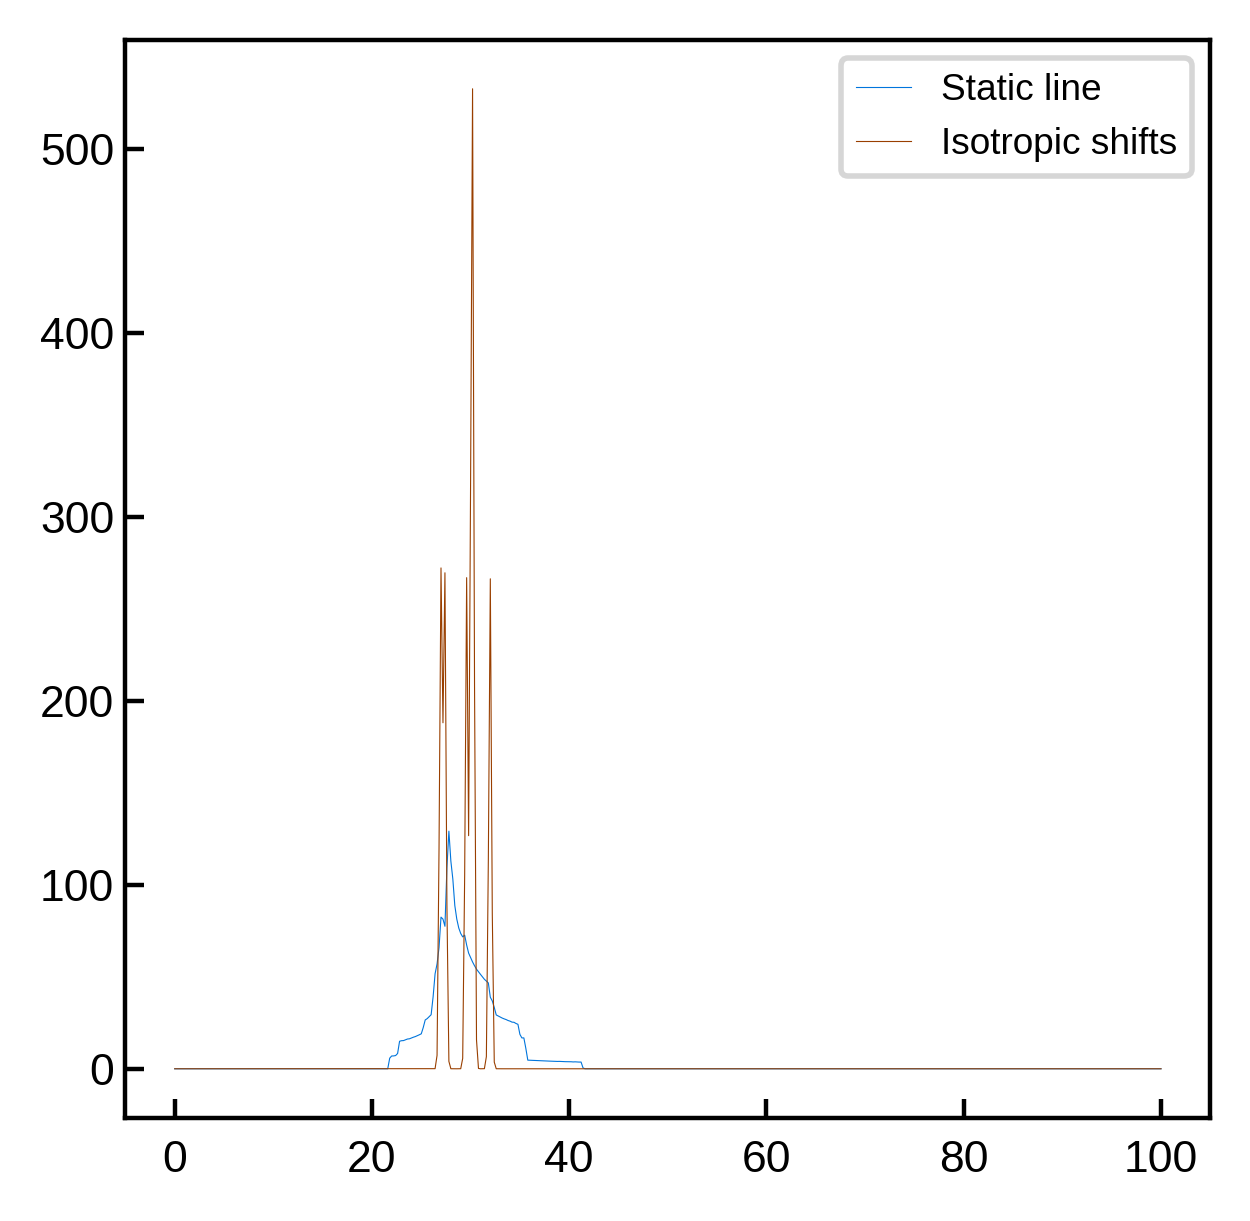

In [31]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(freqs, spec1H_aniso, label='Static line')
ax.plot(freqs, spec1H_iso, label='Isotropic shifts')

ax.legend()

In [32]:
# Now let's look at the static quadrupolar line of 17O
freqRange = 1000000
spec17O_1, freqs = nCalc.spectrum_1d('17O', effects=NMRFlags.Q_1_ORIENT, max_freq=freqRange, min_freq=-freqRange, bins=501)
spec17O_s, freqs = nCalc.spectrum_1d('17O', effects=NMRFlags.Q_STATIC, max_freq=freqRange, min_freq=-freqRange, bins=501)

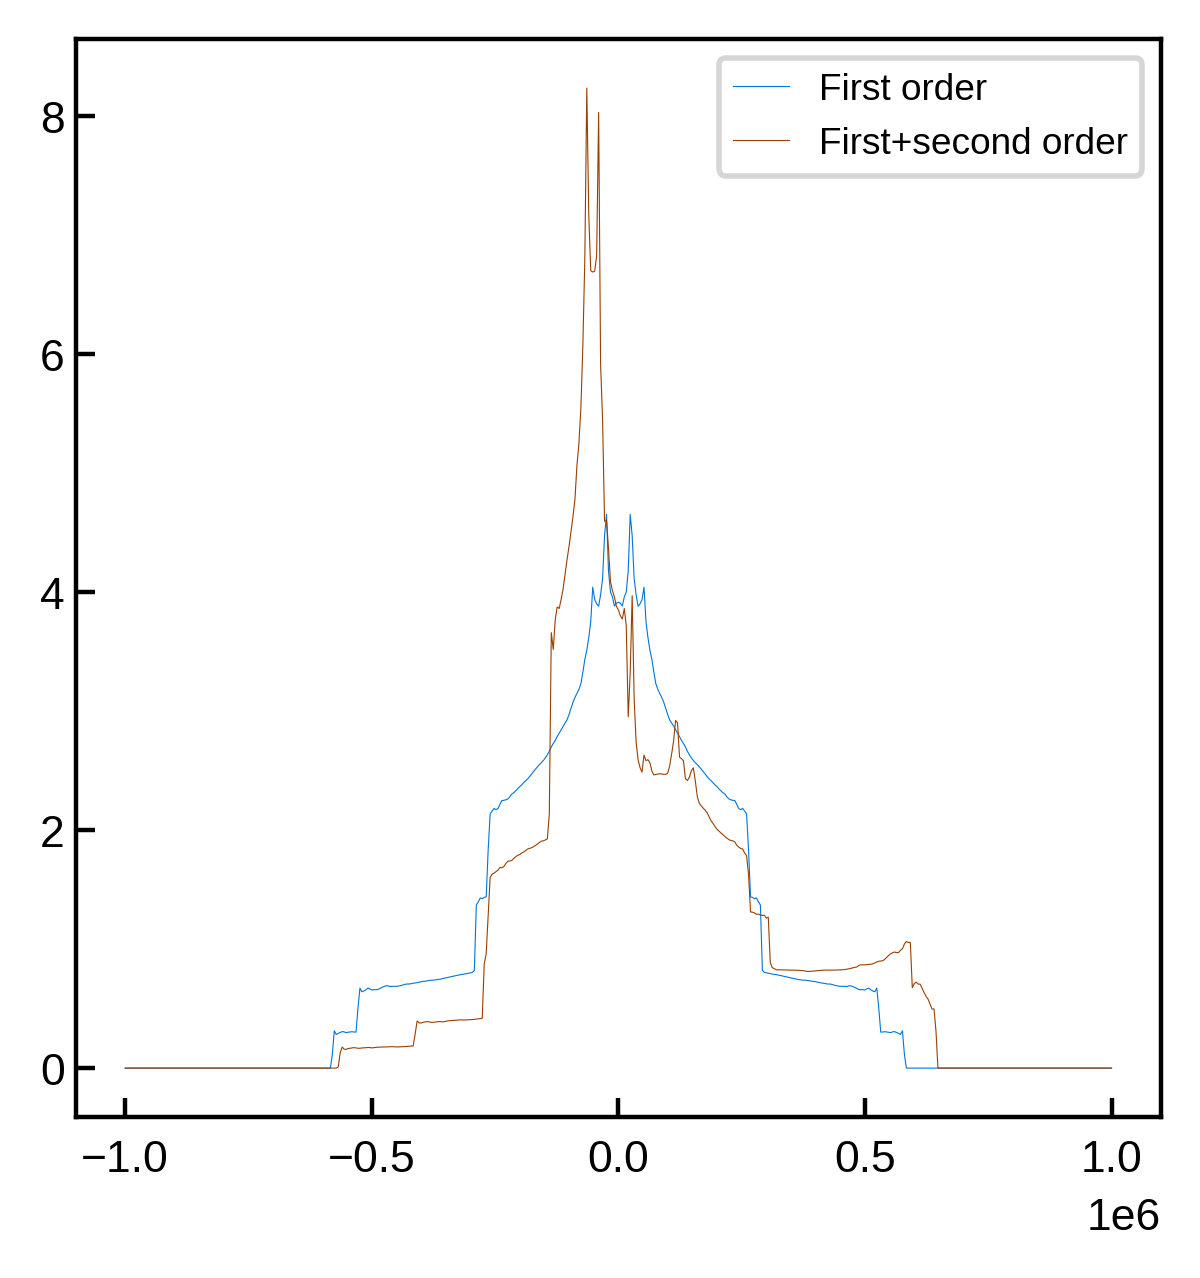

In [33]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(freqs, spec17O_1, label='First order')
ax.plot(freqs, spec17O_s, label='First+second order')

ax.legend()

In [34]:
# There's a number of other possible NMRFlags for various effects...
for fl in NMRFlags._fields:
    print(fl)

CS_ISO
CS_ORIENT
CS
Q_1_ORIENT
Q_2_SHIFT
Q_2_ORIENT_STATIC
Q_2_ORIENT_MAS
Q_2_STATIC
Q_2_MAS
Q_STATIC
Q_MAS
STATIC
MAS


## 7.1 - 2D spectra

We can get a minimal 2D NMR plot simply by running:

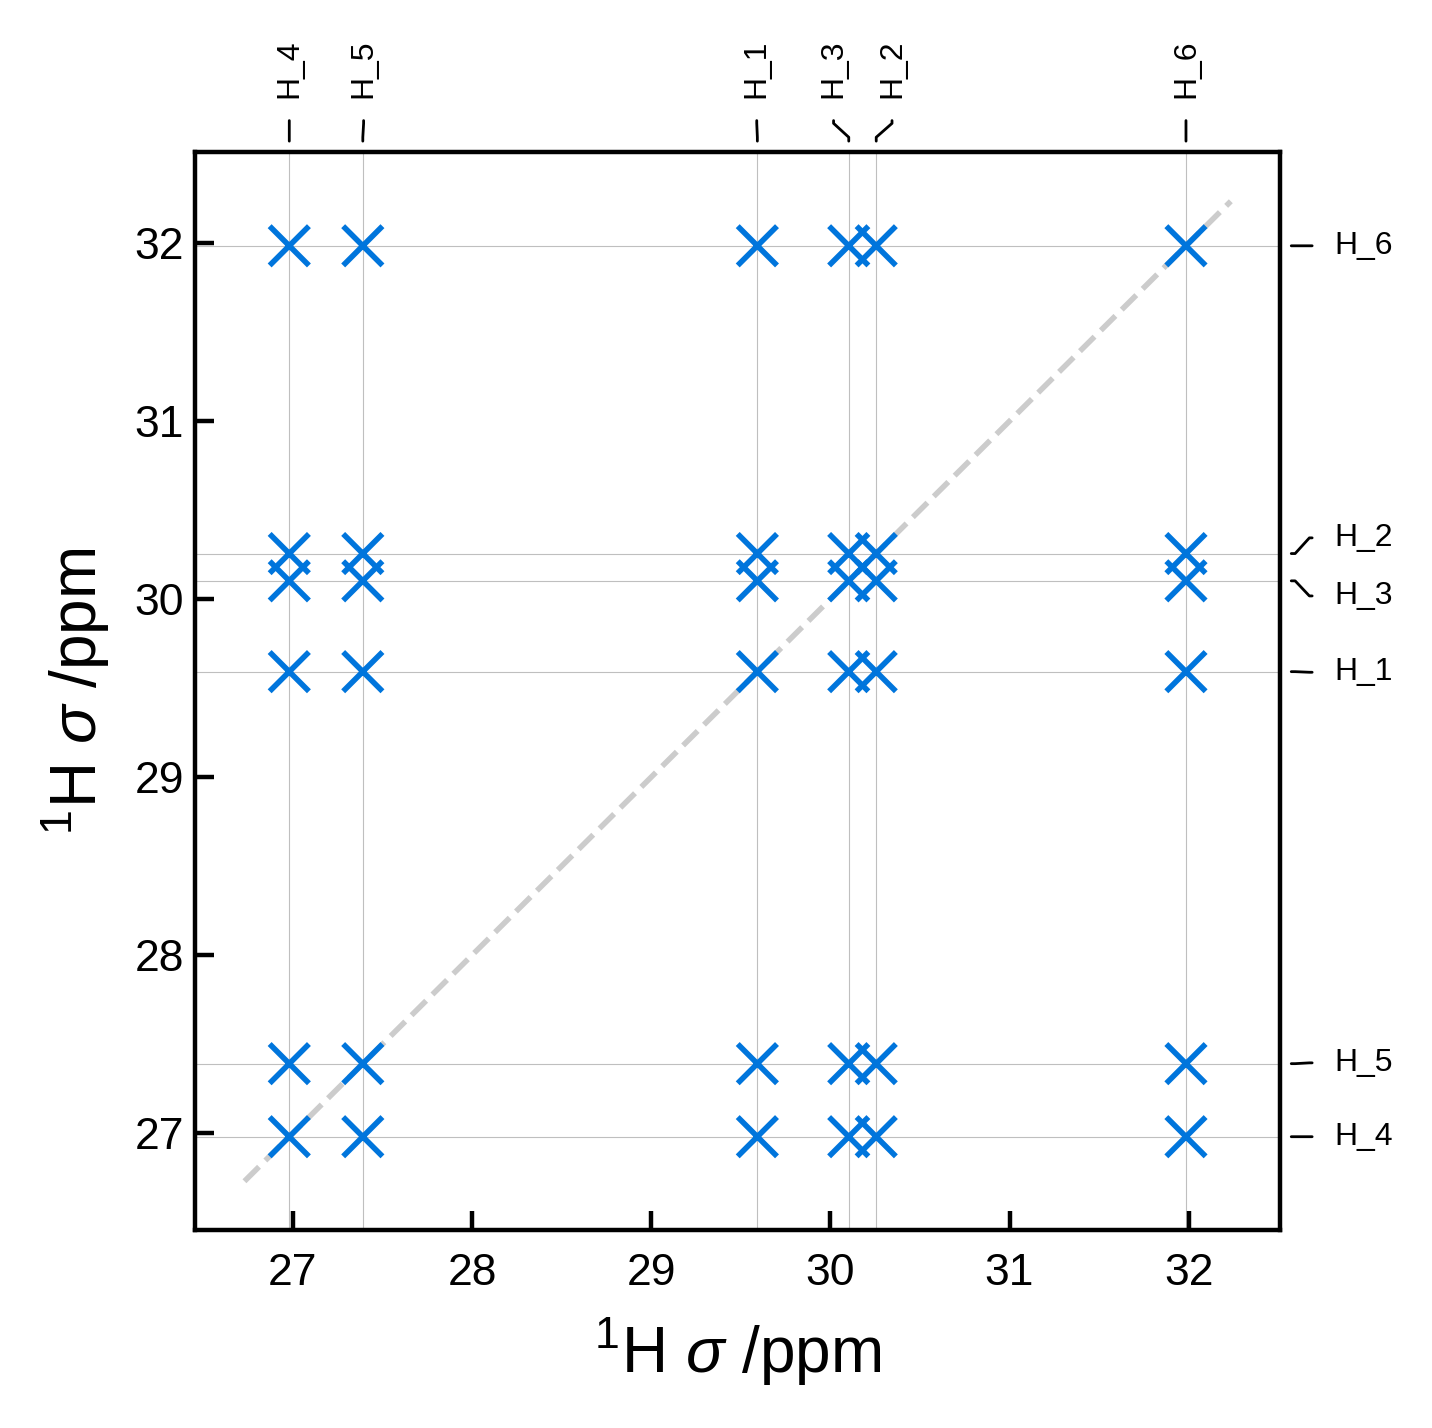

In [110]:
from soprano.calculate.nmr.nmr import Plot2D
atoms = ase_io.read('./tutorial_data/ethanol.magres')
plot = Plot2D(atoms, xelement = 'H') # (yelement = xelement by default)
plot.plot();

For a more complete example, let's set a few more options. Below we plot an proton-proton double-quantum--single-quantum plot.

Plotting chemical shifts since references are given. 
Plotting chemical shifts since references are given. 
Plotting chemical shifts since references are given. 
Plotting chemical shifts since references are given. 
Plotting chemical shifts since references are given. 
Plotting chemical shifts since references are given. 
Plotting 2D NMR spectrum...
Plotting 2D NMR spectrum...
Plotting 2D NMR spectrum...
Plotting 2D NMR spectrum...
Plotting 2D NMR spectrum...
Plotting 2D NMR spectrum...
Plotting H vs H.
Plotting H vs H.
Plotting H vs H.
Plotting H vs H.
Plotting H vs H.
Plotting H vs H.
Indices of H in the atoms object: [0 1 2 3 4 5]
Indices of H in the atoms object: [0 1 2 3 4 5]
Indices of H in the atoms object: [0 1 2 3 4 5]
Indices of H in the atoms object: [0 1 2 3 4 5]
Indices of H in the atoms object: [0 1 2 3 4 5]
Indices of H in the atoms object: [0 1 2 3 4 5]
Indices of H in the atoms object: [0 1 2 3 4 5]
Indices of H in the atoms object: [0 1 2 3 4 5]
Indices of H in the at

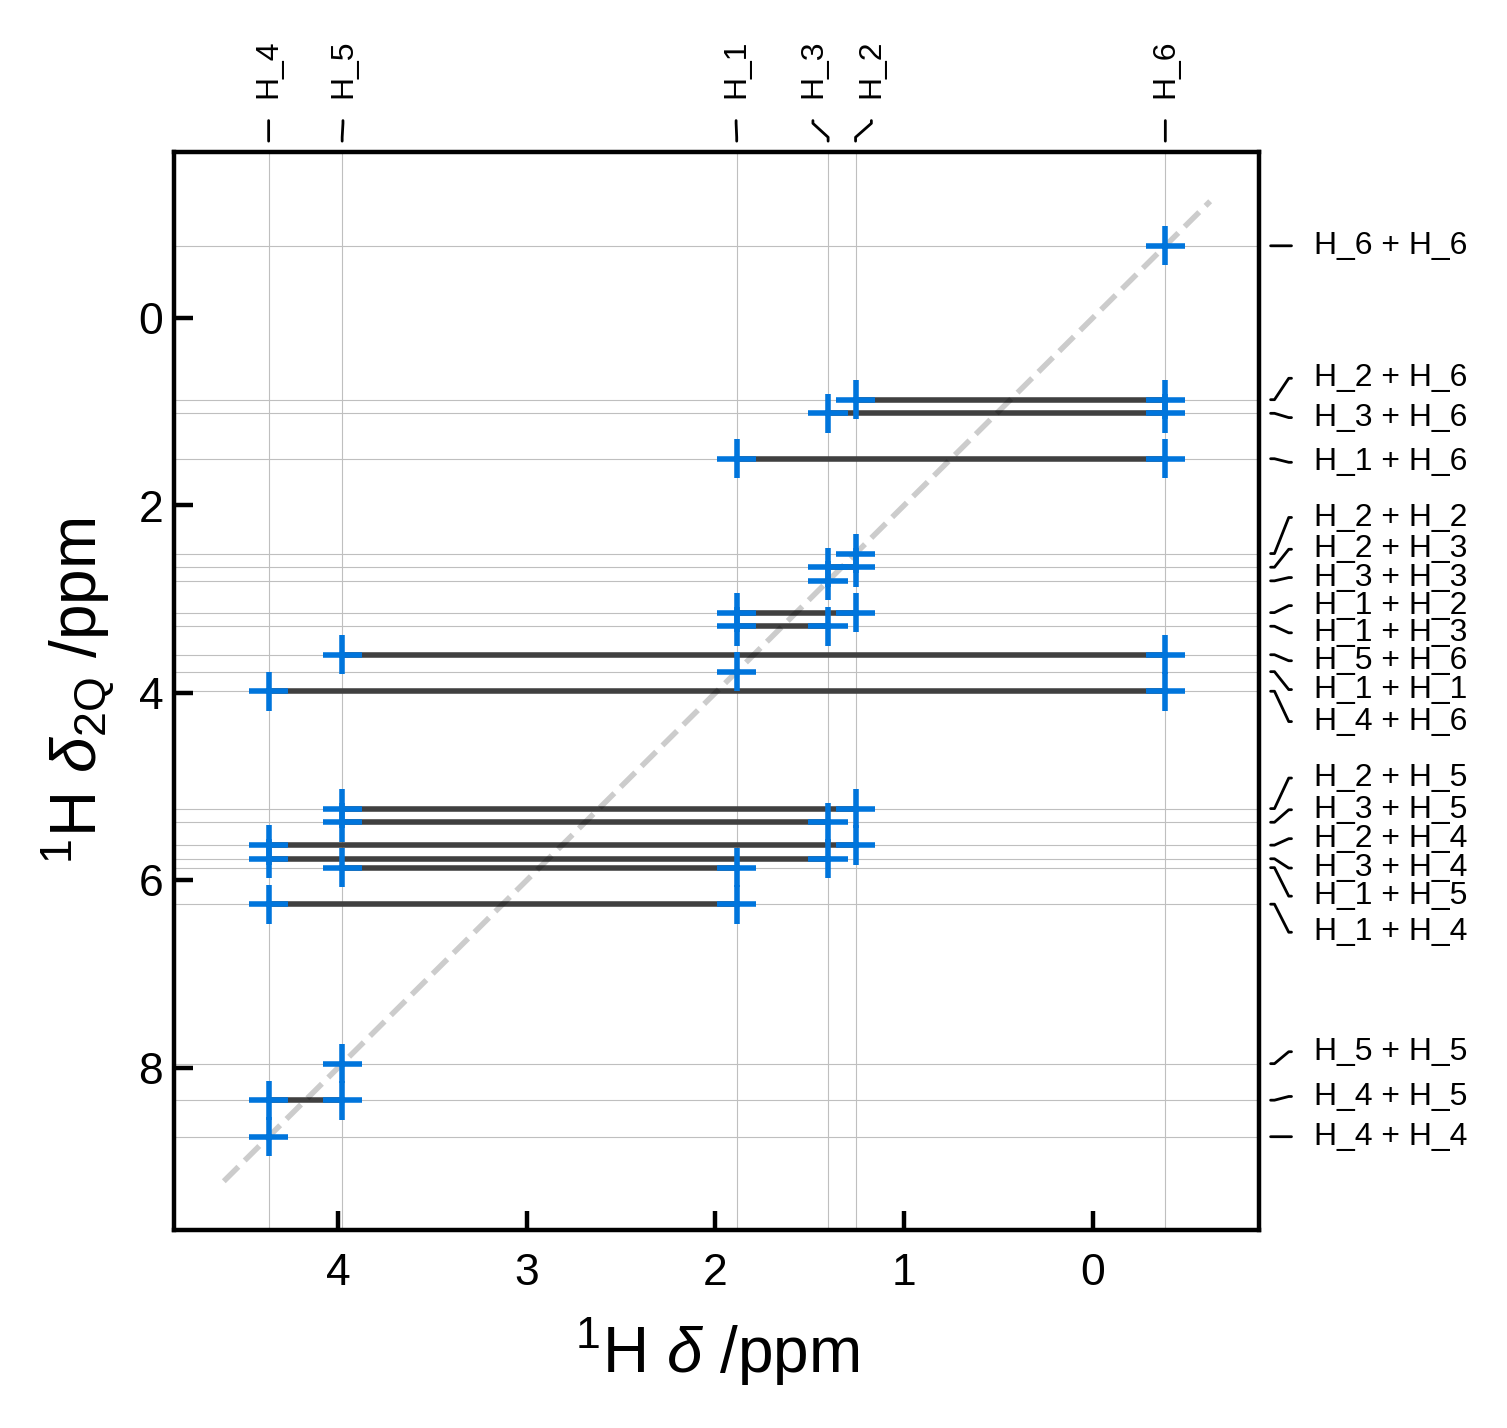

In [111]:
xelement = 'H'
yelement = 'H'
isotopes   = {'H': 1}
references = {'H': 30}
gradients  = {'H': -0.95}
yaxis_order = '2Q'
marker = '+'
marker_color = 'C0'
show_marker_legend = False
scale_marker_by = 'fixed'


plot = Plot2D(
            atoms,
            xelement = xelement,
            yelement = yelement,
            references = references,
            gradients = gradients,
            isotopes=isotopes,
            yaxis_order=yaxis_order,
            marker=marker,
            scale_marker_by=scale_marker_by,
            marker_color = marker_color,
            show_marker_legend=show_marker_legend,
            )
plot.plot();


###  Customising the 2D NMR

You might want to supply the pairs of sites together with a measure of their correlation strength. This can be done by supplying the `pairs` argument with a list of tuples of the form `(i, j)` and the `markersizes` argument. The `markersizes` argument should be a list of the same length as `pairs` and contain the size of the marker for each pair. The sizes are normalised to the maximum size in the list.

The pair indices must correspond to those of the atoms in the `Atoms` object.

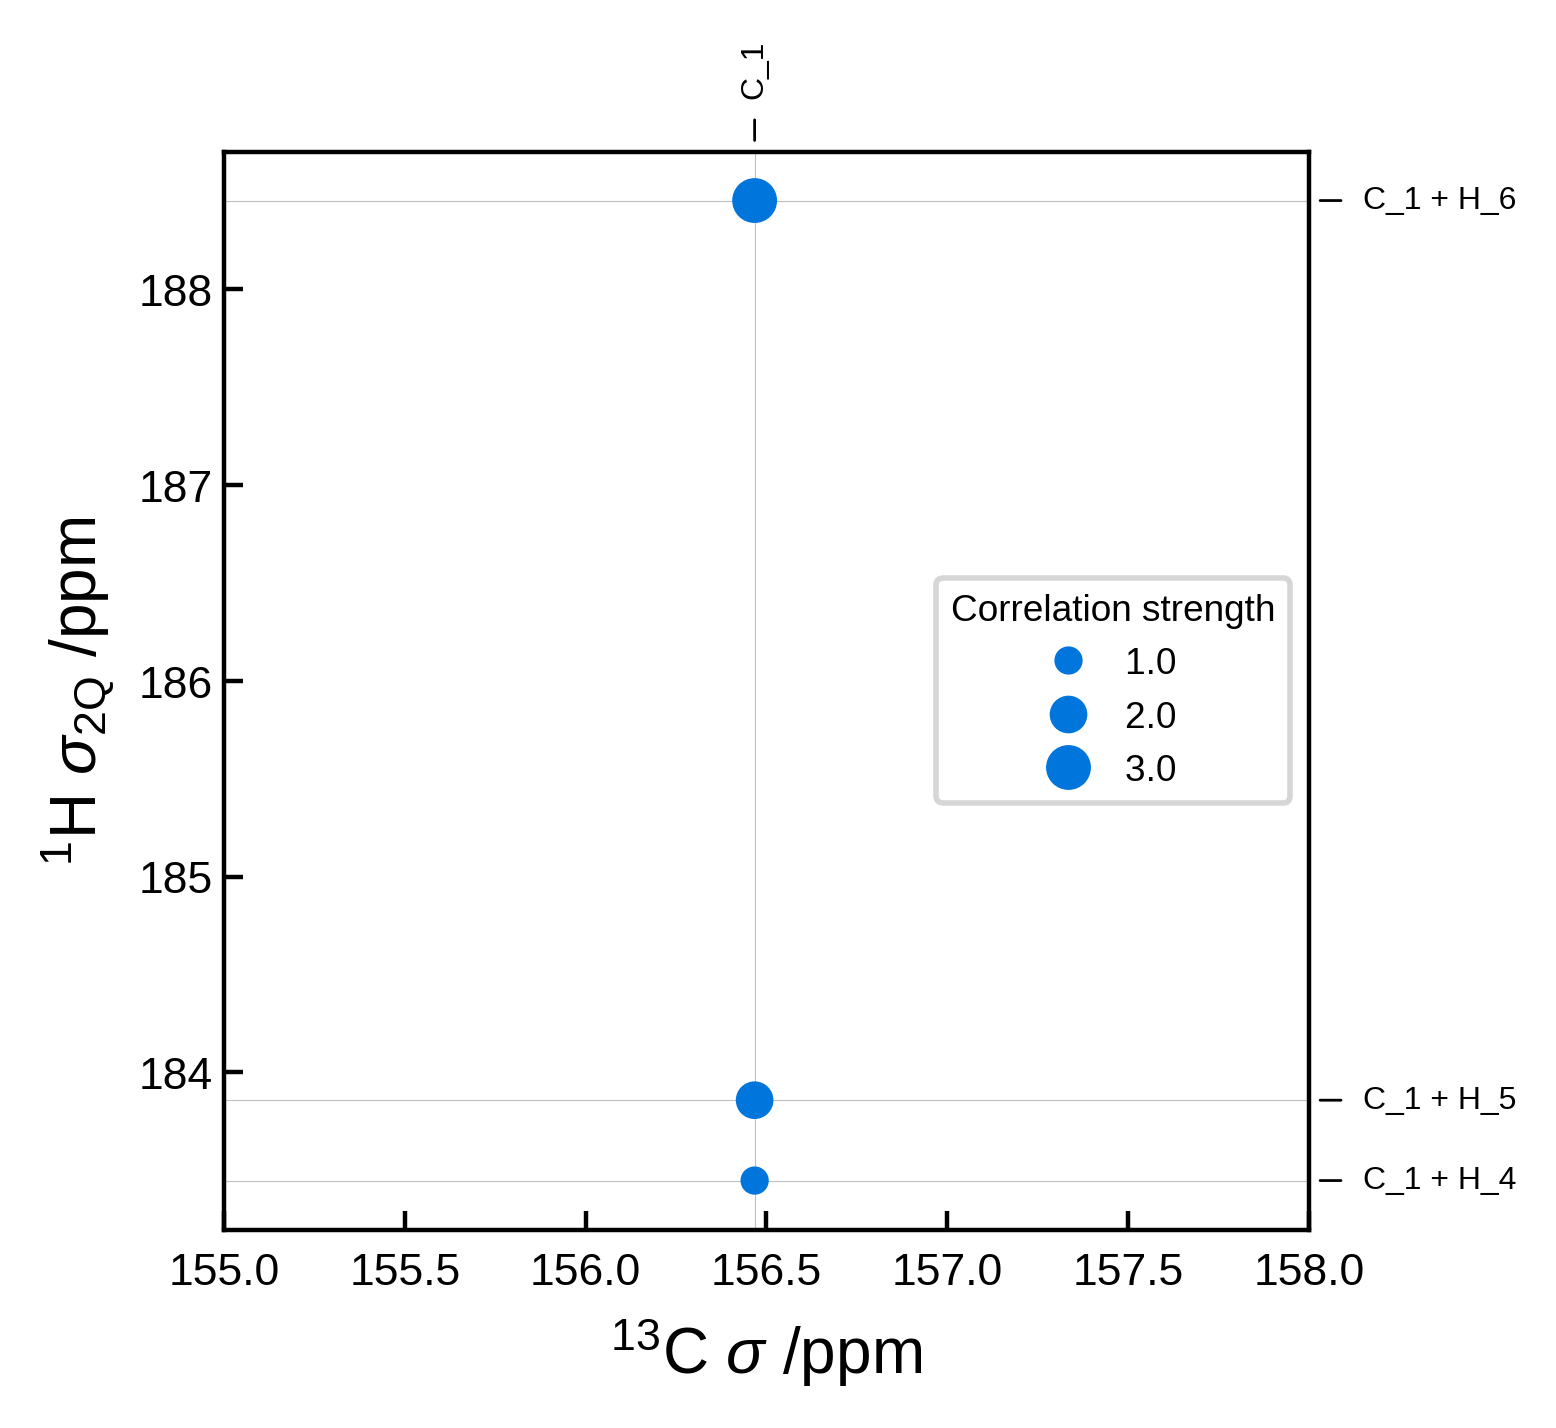

In [104]:
# Here's an artificial example of how you might select custom pairs to plot
pairs = [(6,3), (6,4), (6,5)]
# and assign them different markersizes to indicate the relative correlation strength
# (these are normalised internally such that the max absolute value is set to the max marker size)
markersizes=  [1,2,3]

xelement = 'C'
yelement = 'H'
yaxis_order = '2Q'
marker = 'o'
show_marker_legend = True
xlim = (155, 158)

plot = Plot2D(
            atoms,
            pairs = pairs,
            markersizes = markersizes,
            xelement = xelement,
            yelement = yelement,
            yaxis_order=yaxis_order,
            marker=marker,
            show_marker_legend=show_marker_legend,
            xlim=xlim,
            )
fig, ax = plot.plot()


Alternatively, we can instead supply the peaks as a list of `Peak2D` objects. This allows us to set the peak location, strength etc. directly. The `pairs` and `markersizes` arguments are ignored in this case.

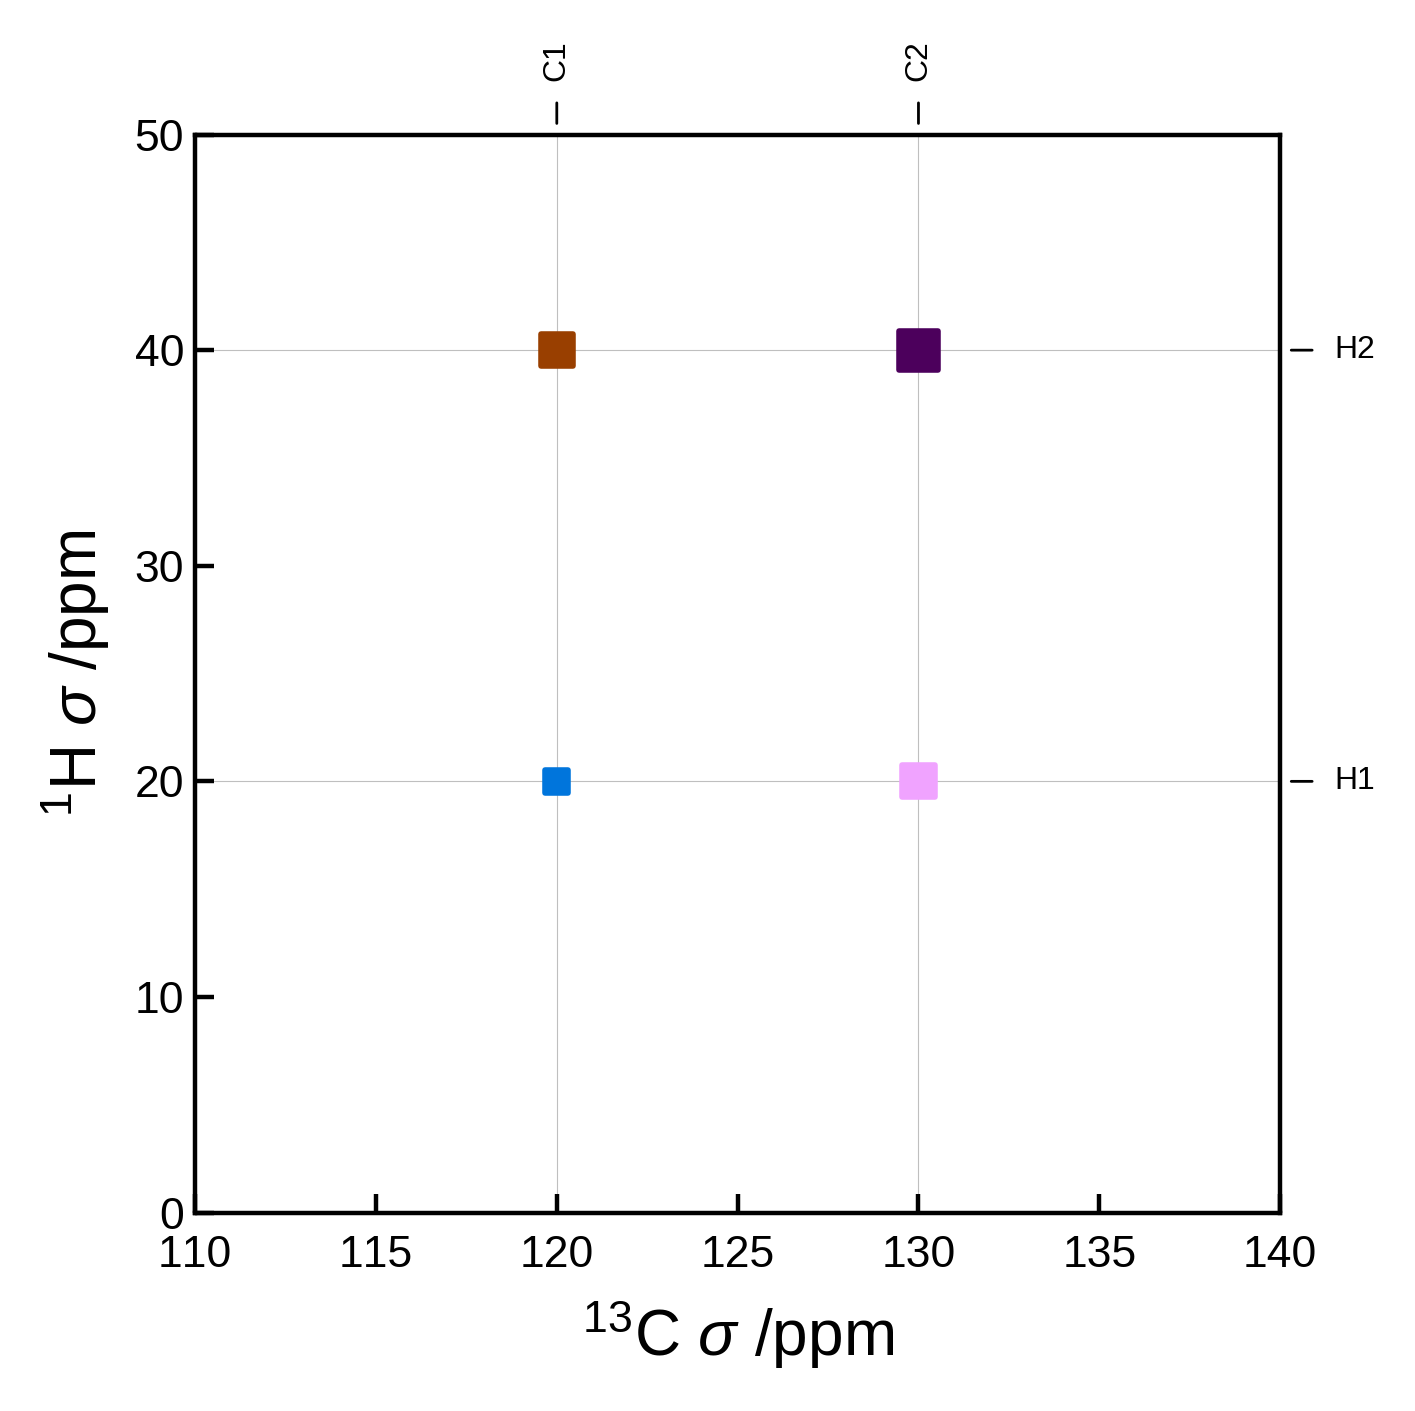

In [119]:
from soprano.calculate.nmr.utils import Peak2D

xlabel = r"$\mathrm{^{13}C}$ $\sigma$ /ppm"
ylabel = r"$\mathrm{^{1}H}$ $\sigma$ /ppm"
marker = 's'
C_ms = [120, 130]
H_ms = [20, 40]
peaks = []
for iC, C in enumerate(C_ms):
    for iH, H in enumerate(H_ms):
        peaks.append(Peak2D(C, H, f'C{iC+1}', f'H{iH+1}', correlation_strength=iC + iH+1))

# we can also get creative:
peaks[0].color = 'C0'
peaks[1].color = 'C1'
peaks[2].color = 'C2'
peaks[3].color = 'C3'

plot = Plot2D(
            atoms,
            peaks = peaks,
            marker=marker,
            x_axis_label=xlabel,
            y_axis_label=ylabel,
            xlim=(110, 140),
            ylim=(0, 50),
            )
fig, ax = plot.plot()


If you don't want to create the Peak2D objects completely from scratch, we can use the `get_peaks` to get the automatically generated peaks, edit them and then plot. 

For example, we can use Soprano to compute the J-coupling values for each peak and use that to determine the correlation strength:

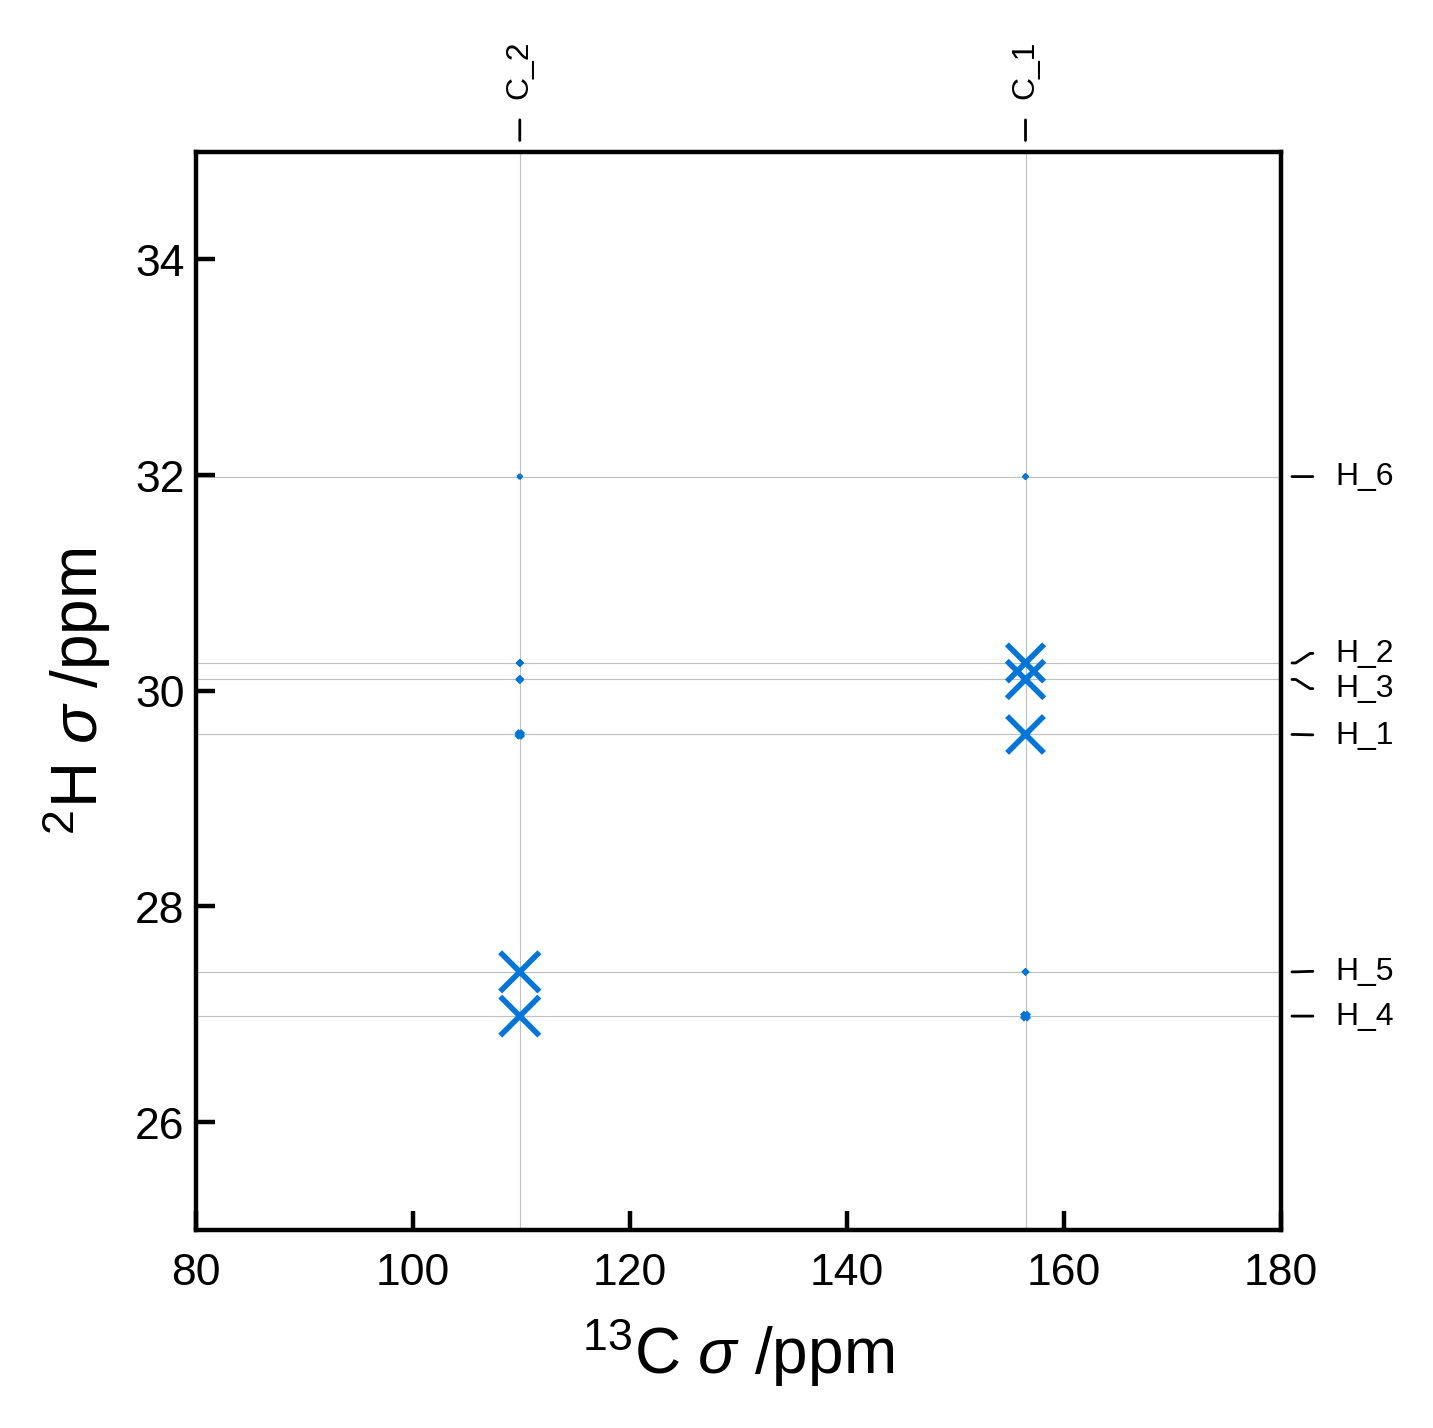

In [123]:
from soprano.properties.nmr.isc import JCIsotropy
isotopes = {'C': 13, 'H': 2}
plot = Plot2D(
            atoms,
            xelement = 'C',
            yelement = 'H',
            isotopes = isotopes,
            xlim=(80, 180),
            ylim=(25, 35),
            )
# get the peaks
peaks = plot.get_peaks()

# Set the J-coupling for each peak to be the correlation strength
for peak in peaks:
    i,j = sorted([peak.idx_x, peak.idx_y])
    jcoup = JCIsotropy().get(atoms,tag = 'isc', sel_i = [i], sel_j = [j], isotopes = isotopes)
    peak.correlation_strength = jcoup[(i,j)]

# update peaks
plot.peaks = peaks

# plot
fig, ax = plot.plot()


More complex plots are possible by first manually generating the matplotlib figure and axes and passing them to the Plot2D class. For example, we can create a customised plot in which we combine 2D and 1D spectra:


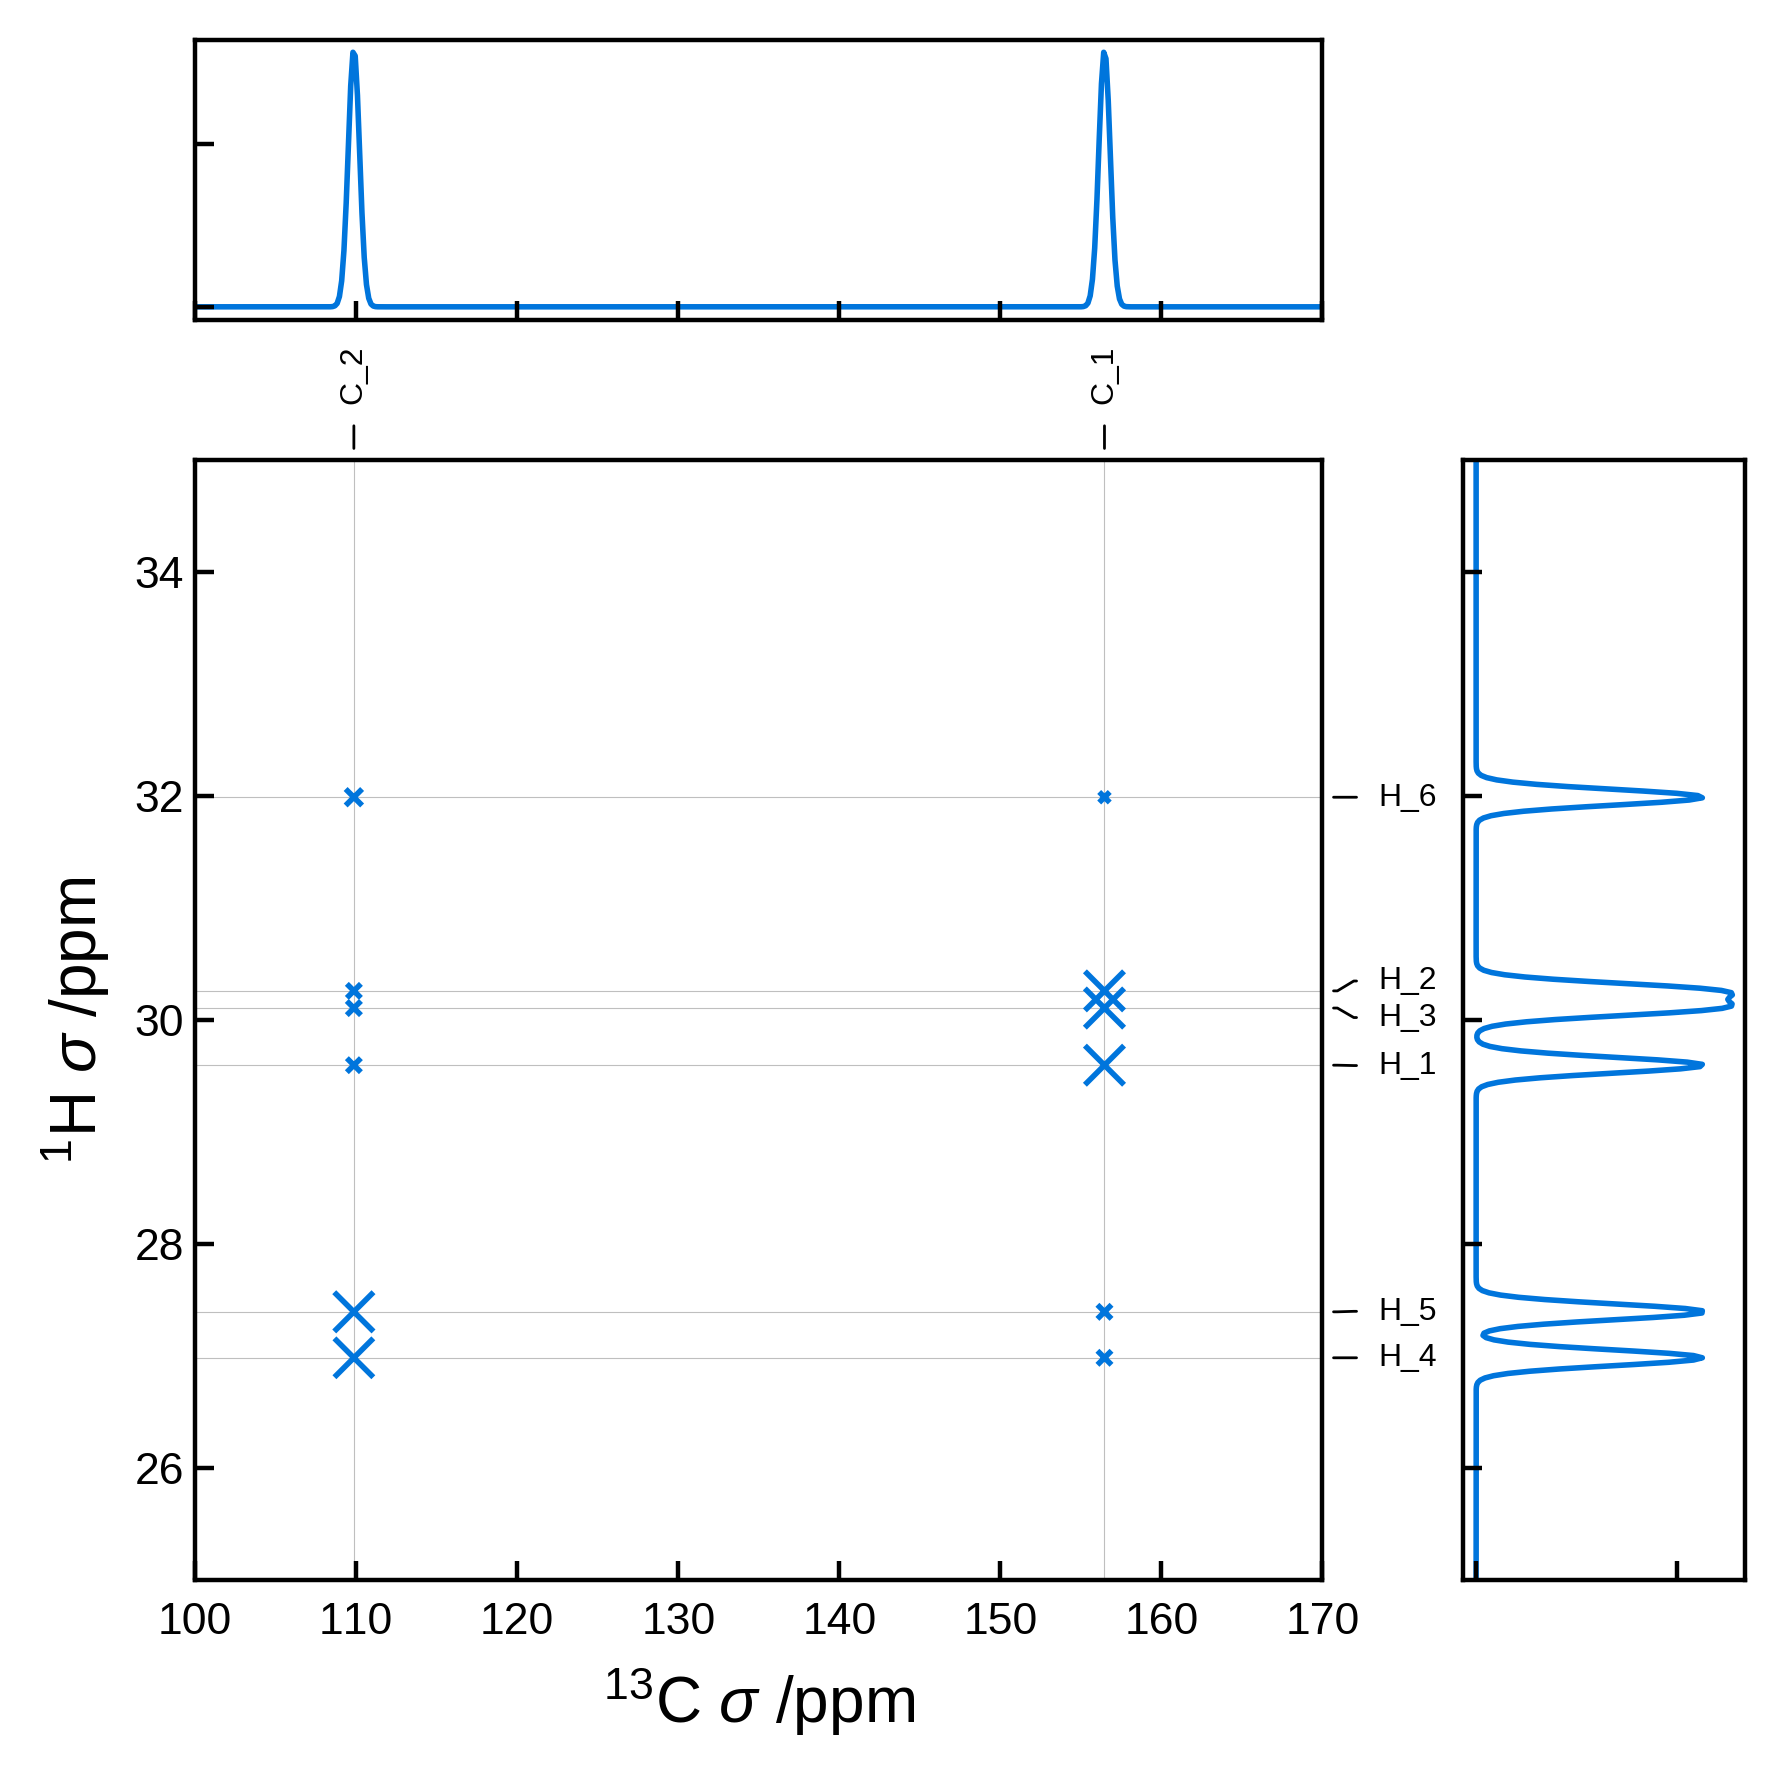

In [124]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from soprano.calculate.nmr.nmr import NMRCalculator, NMRFlags

xlims = (100, 170)
ylims = (25, 35)
nbins = 501

# Compute the spectrum for protons; from soprano.calculate.nmr.nmr import NMRCalculator, NMRFlags

nCalc = NMRCalculator(atoms) # We create the calculator here
# Set a powder averaging. Higher values of N mean finer average. Here we only care about the isotropic lines, so we can set N=1
nCalc.set_powder(N=1)
# proton spectrum
spec1H_iso, freqs1H   = nCalc.spectrum_1d('1H', effects=NMRFlags.MAS, max_freq=ylims[1], min_freq=ylims[0], bins=nbins, freq_broad=0.1)
# carbon spectrum
spec13C_iso, freqs13C = nCalc.spectrum_1d('13C', effects=NMRFlags.MAS, max_freq=xlims[1], min_freq=xlims[0], bins=nbins, freq_broad=0.5)


# Create a figure with the 2D plot and 2 1D plots above and to the right of the 2D plot
fig = plt.figure(figsize=(5,5))
gs = GridSpec(2, 2, width_ratios=[4, 1], height_ratios=[1, 4])

# Create the 1D plots
ax1d_x = fig.add_subplot(gs[0, 0])
ax1d_x.plot(freqs13C, spec13C_iso, lw=1)
ax1d_x.set_xlim(xlims)
ax1d_x.set_xticklabels([])
ax1d_x.set_yticklabels([])

ax1d_y = fig.add_subplot(gs[1, 1])
ax1d_y.plot(spec1H_iso, freqs1H, lw=1)
ax1d_y.set_ylim(ylims)
ax1d_y.set_xticklabels([])
ax1d_y.set_yticklabels([])

# Create the 2D plot
ax2d = fig.add_subplot(gs[1, 0])
plot = Plot2D(
    atoms,
    xelement = 'C',
    yelement = 'H',
    ax=ax2d,
    ylim=ylims,
    xlim=xlims,
    marker_color='C0',
    scale_marker_by='dipolar',
    marker='x',
    )

plot.plot()
#increase space between subplots
plt.subplots_adjust(wspace=0.2, hspace=0.2)


# 6 - Euler angles



[In progress]